In [1]:
from keras.datasets import cifar10 # subroutines for fetching the CIFAR-10 dataset
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.utils import to_categorical

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#from __future__ import print_function

Using TensorFlow backend.


We will build an autoencoder based on the mnist (hand written digits) dataset.

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will perform some basic pre-processing.
We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


We'll start simple, with a single fully-connected neural layer as encoder and as decoder

In [4]:
from keras.layers import Input, Dense
from keras.models import Model


encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats (28X28 digits)


input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

In [5]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# creating a decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [6]:
encoded_input

<tf.Tensor 'input_2:0' shape=(None, 32) dtype=float32>

In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.6942 - val_loss: 0.6942
Epoch 2/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.6941 - val_loss: 0.6940
Epoch 3/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.6939 - val_loss: 0.6939
Epoch 4/20
60000/60000 [==============================] - 2s 29us/step - loss: 0.6938 - val_loss: 0.6938
Epoch 5/20
60000/60000 [==============================] - 2s 25us/step - loss: 0.6937 - val_loss: 0.6936
Epoch 6/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.6935 - val_loss: 0.6935
Epoch 7/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 8/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.6931 - val_loss: 0.6930
Epoch

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [10]:
encoded_imgs[0].shape

(32,)

In [11]:
decoded_imgs[0].shape

(784,)

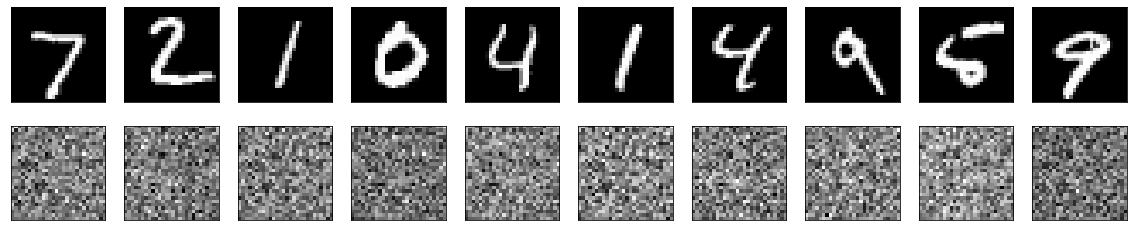

In [12]:
# use Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Deep autoencoder
Instead of using only 1 hidden layer we will use more in order to capture a more HL concepts.

In [13]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               1011

In [14]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.6919 - val_loss: 0.6918
Epoch 2/20
60000/60000 [==============================] - 4s 74us/step - loss: 0.6918 - val_loss: 0.6917
Epoch 3/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.6917 - val_loss: 0.6916
Epoch 4/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.6916 - val_loss: 0.6915
Epoch 5/20
60000/60000 [==============================] - 4s 58us/step - loss: 0.6915 - val_loss: 0.6914
Epoch 6/20
60000/60000 [==============================] - 4s 60us/step - loss: 0.6914 - val_loss: 0.6913
Epoch 7/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.6913 - val_loss: 0.6912
Epoch 8/20
60000/60000 [==============================] - 3s 55us/step - loss: 0.6912 - val_loss: 0.6912 0s - loss: 0.69
Epoch 9/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.6911 - val_lo

In [15]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

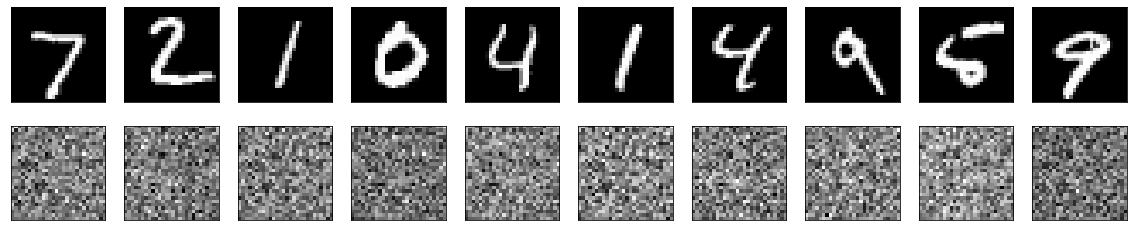

In [16]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN-Based Autoencoder

In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0   

Let us re-load the data in the right form

In [18]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

In [19]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 69s 1ms/step - loss: 0.6905 - val_loss: 0.6892
Epoch 2/20
60000/60000 [==============================] - 84s 1ms/step - loss: 0.6873 - val_loss: 0.6849
Epoch 3/20
60000/60000 [==============================] - 101s 2ms/step - loss: 0.6809 - val_loss: 0.6757
Epoch 4/20
60000/60000 [==============================] - 104s 2ms/step - loss: 0.6658 - val_loss: 0.6515
Epoch 5/20
60000/60000 [==============================] - 103s 2ms/step - loss: 0.6174 - val_loss: 0.5663
Epoch 6/20
60000/60000 [==============================] - 107s 2ms/step - loss: 0.5130 - val_loss: 0.4889
Epoch 7/20
60000/60000 [==============================] - 89s 1ms/step - loss: 0.4798 - val_loss: 0.4774
Epoch 8/20
60000/60000 [==============================] - 96s 2ms/step - loss: 0.4692 - val_loss: 0.4673
Epoch 9/20
60000/60000 [==============================] - 93s 2ms/step - loss: 0.4593 - val_loss: 0.4575
E

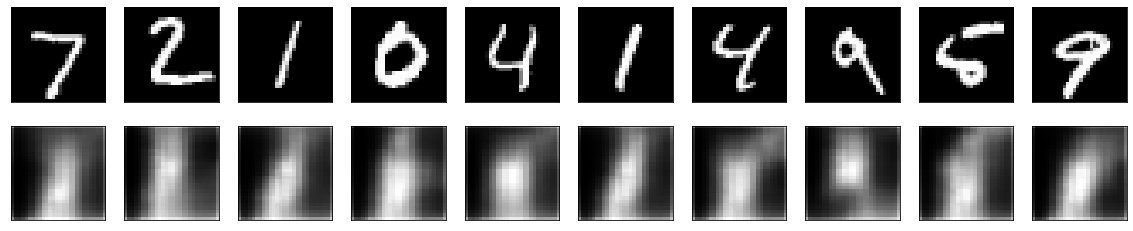

In [20]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Autoencoders with Denoising
This time, let's bring noisy images, and let's try to build an autoencoder that will seperate noise from signal.
Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [21]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Plot the noisy images

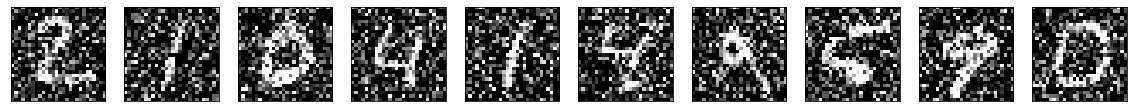

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

much more noisy now. Let's see what our autoencoder will do

In [23]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [24]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 143s 2ms/step - loss: 0.6785 - val_loss: 0.6730
Epoch 2/20
60000/60000 [==============================] - 132s 2ms/step - loss: 0.6638 - val_loss: 0.6521
Epoch 3/20
60000/60000 [==============================] - 135s 2ms/step - loss: 0.6294 - val_loss: 0.5999
Epoch 4/20
60000/60000 [==============================] - 131s 2ms/step - loss: 0.5562 - val_loss: 0.5185
Epoch 5/20
60000/60000 [==============================] - 131s 2ms/step - loss: 0.4994 - val_loss: 0.4943
Epoch 6/20
60000/60000 [==============================] - 125s 2ms/step - loss: 0.4874 - val_loss: 0.4879
Epoch 7/20
60000/60000 [==============================] - 133s 2ms/step - loss: 0.4811 - val_loss: 0.4817
Epoch 8/20
60000/60000 [==============================] - 135s 2ms/step - loss: 0.4748 - val_loss: 0.4751
Epoch 9/20
60000/60000 [==============================] - 148s 2ms/step - loss: 0.4681 - val_loss: 0.4

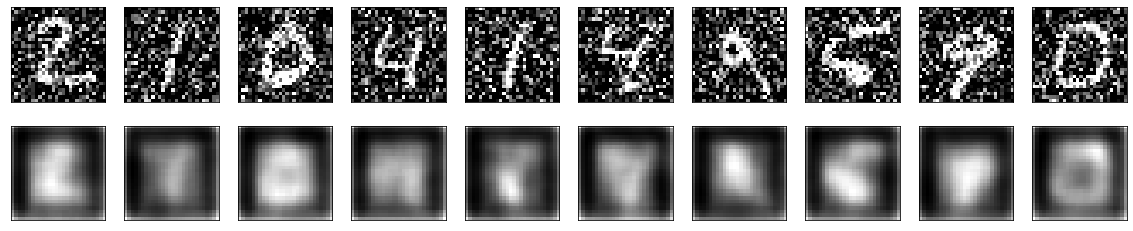

In [25]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i )
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()